In [1]:
import os

from collections import OrderedDict

import pandas as pd
import numpy as np

from Standard_functions import get_user_split_data, plot_fit_score_pred

import warnings

warnings.filterwarnings('always') 
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
os.chdir('Data/')

## Loading our Datasets

``` python
orders = pd.read_csv('orders.csv')
products_prior = pd.read_csv('order_products__prior.csv')
products_train = pd.read_csv('order_products__train.csv')

products_train = products_train.merge(orders.drop('eval_set', axis=1), on='order_id')
products_prior = products_prior.merge(orders.drop('eval_set', axis=1), on='order_id')

rs = np.random.RandomState(101)

total_users = products_train['user_id'].unique()
small_df_users = rs.choice(total_users, 
               size=int(total_users.shape[0] * .03), 
               replace=False)

products_prior_reduced = products_prior[products_prior['user_id'].isin(small_df_users)]
products_train_reduced = products_train[products_train['user_id'].isin(small_df_users)]

pd.to_pickle(products_prior_reduced,'products_prior_reduced')
pd.to_pickle(products_train_reduced,'products_train_reduced')
```

In [20]:
ord_df = pd.read_csv('orders.csv')

In [3]:
prod_df = pd.read_csv('products.csv')

In [4]:
ord_prod_prior_df = pd.read_pickle('products_prior_reduced')

In [5]:
products_train = pd.read_pickle('products_train_reduced')

## Preparing our Test Data

### Organizing the data

Below I've created a new DataFrame that aggregared user-product info. I've also taken this as an opportunity to create a count of the number of orders for each product.

In [7]:
df_user_product = (ord_prod_prior_df.groupby(['product_id','user_id'],as_index=False) 
                              .agg({'order_id':'count'}) 
                              .rename(columns={'order_id':'num_ord_per_user_per_prod'}))

test_ids = ord_prod_prior_df['user_id'].unique() 
df = df_user_product[df_user_product['user_id'].isin(test_ids)]

This is a DataFrame containing every single user_id, for every user_id you have every product they've ever ordered. The features of those products will be created mostly by grouping by user_id (i.e. values for features will be user_id specific and, within that, item specific).
One column for this DataFrame is labeled `in_cart` and will be our target variable during testing.

In [8]:
test_carts = (products_train.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))

df = df.merge(test_carts, on='user_id')
df['in_cart'] = (df.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

## Feature Engineering

Our feature engineering began in the 'Organizing data section.  
We will visualize that first feature below and begin creating new features.

<Figure size 648x648 with 0 Axes>

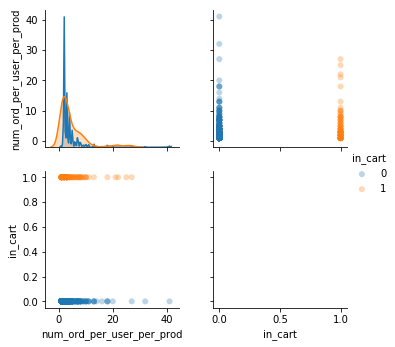

Our f1-score is 0.08701984343710177
The coefficients are: 
                     Features  Coefficients
0  num_ord_per_user_per_prod        0.1508
And we've predicted 50145 non-re-orders and 521 re-orders.


In [9]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

As you can see, we're setting the bar pretty low.

## Product Features
Note that product features are not user-specific.

### `product_total_orders`
Total number of orders placed for a given product.
### `product_avg_add_to_cart_order`
Average order in which a product was add to a users cart.

In [10]:
prod_features = ['product_total_orders','product_avg_add_to_cart_order']

df_prod_features = (ord_prod_prior_df.groupby(['product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order','mean')])))
df_prod_features.columns = ['product_id'] + prod_features
df = df.merge(df_prod_features, on='product_id')

`product_total_orders` had some pretty enourmous rightward skew that ultimately resulted in the model producing 0 positive predictions. As a result I took the log base 2 transformation to punish outliers.  
Note that I attempted a log base 10 transformation but log base 2 had better results.

In [11]:
df.product_total_orders = np.log2(df.product_total_orders)

<Figure size 648x648 with 0 Axes>

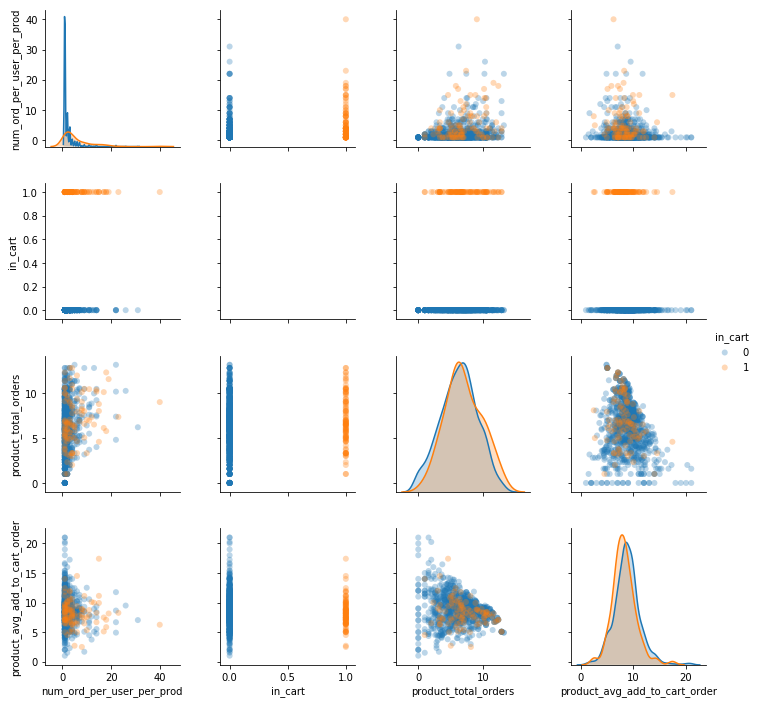

Our f1-score is 0.08452830188679246
The coefficients are: 
                         Features  Coefficients
0      num_ord_per_user_per_prod        0.1318
1           product_total_orders        0.1018
2  product_avg_add_to_cart_order       -0.0747
And we've predicted 49669 non-re-orders and 479 re-orders.


In [12]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User Features
`'user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order'`

In [13]:
user_features = ['user_total_orders','user_avg_cartsize',
                 'user_total_products','user_avg_days_since_prior_order']

df_user_features = (ord_prod_prior_df.groupby(['user_id'],as_index=False)
                    .agg(OrderedDict(
                       [('order_id',
                         ['nunique', # user_total_orders
                        (lambda x: x.shape[0] / x.nunique())]), # user_avg_cartsize
                        ('product_id','nunique'), # user_total_products
                        ('days_since_prior_order','mean')]))) # user_avg_days_since_prior_order
df_user_features.columns = ['user_id'] + user_features
df = df.merge(df_user_features, on='user_id')

<Figure size 648x648 with 0 Axes>

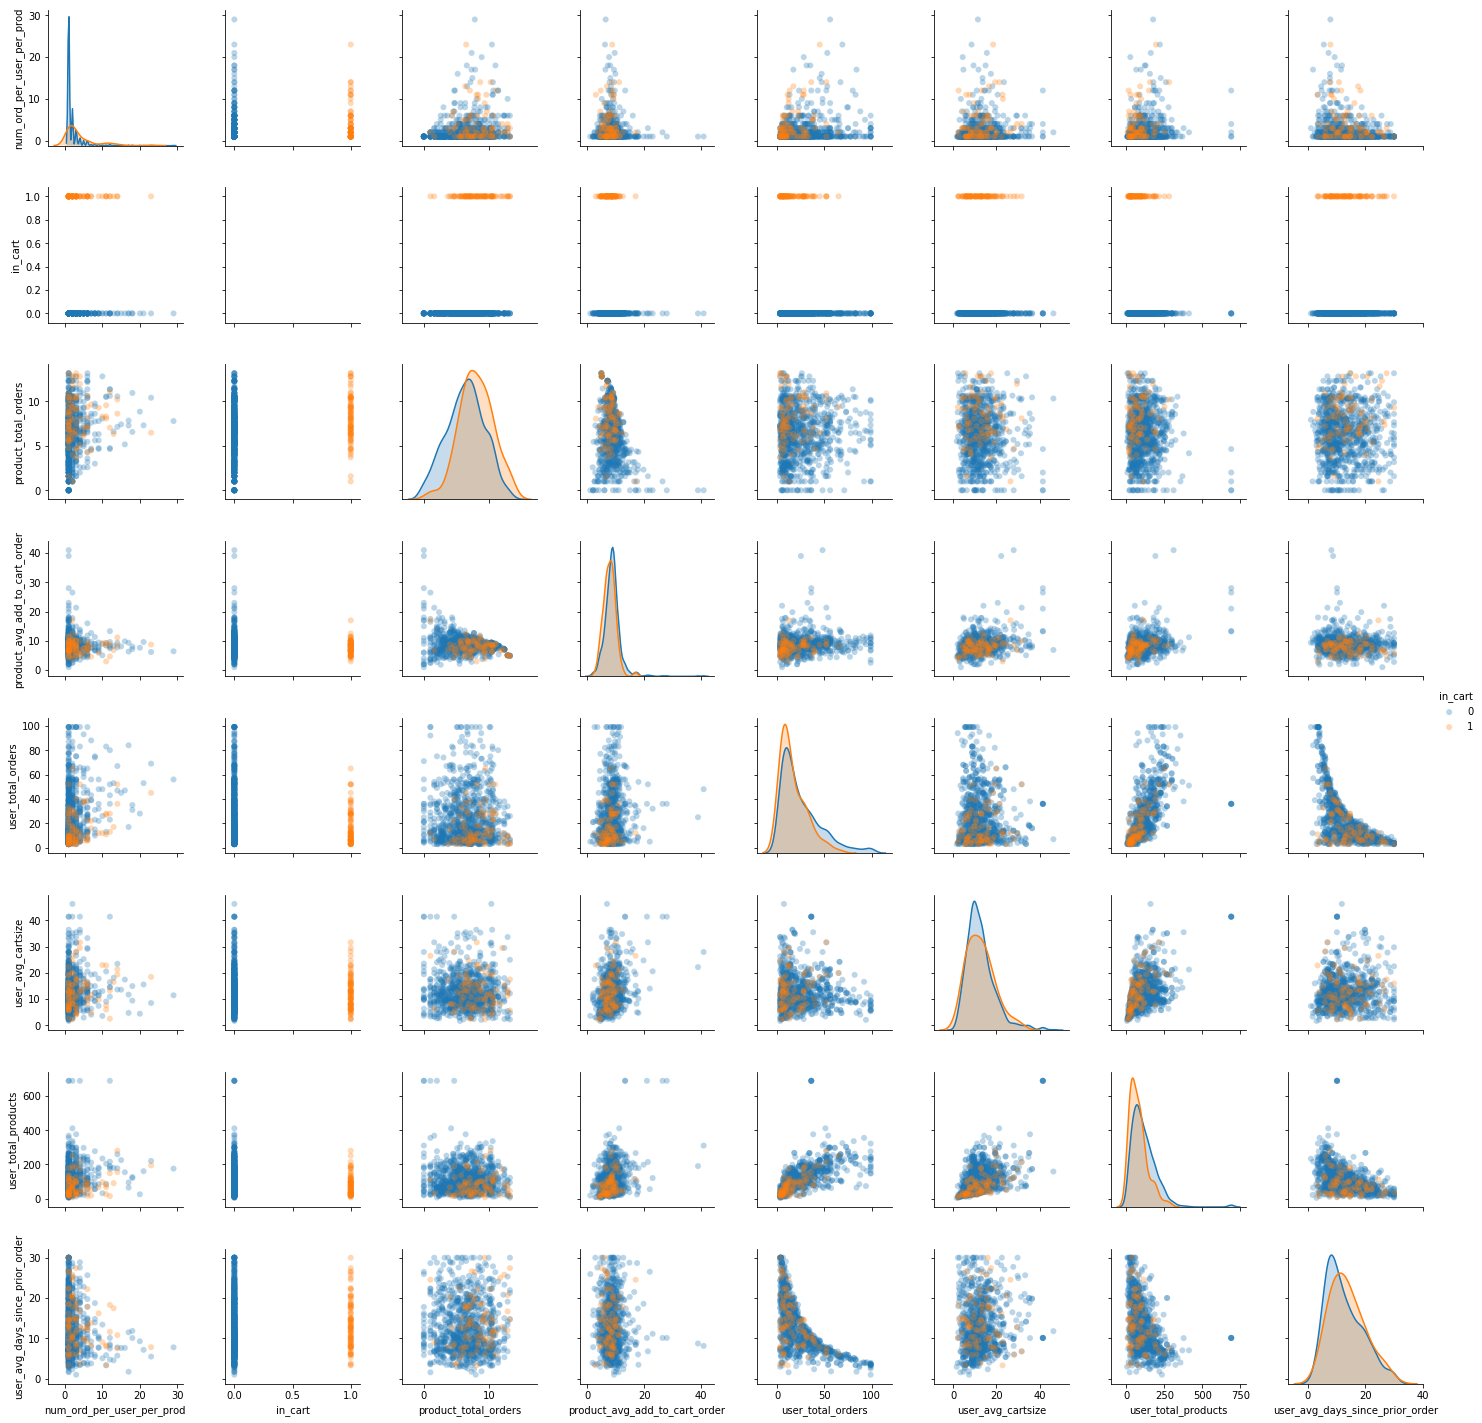

Our f1-score is 0.12017008689221668
The coefficients are: 
                           Features  Coefficients
0        num_ord_per_user_per_prod        0.1910
1             product_total_orders        0.0856
2    product_avg_add_to_cart_order       -0.0628
3                user_total_orders       -0.0249
4                user_avg_cartsize        0.0459
5              user_total_products       -0.0056
6  user_avg_days_since_prior_order       -0.0062
And we've predicted 49560 non-re-orders and 588 re-orders.


In [14]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## User-Product features

In [15]:
user_prod_features = ['user_product_avg_add_to_cart_order']

df_user_prod_features = (ord_prod_prior_df.groupby(
                        ['product_id','user_id'],as_index=False) \
                        .agg(OrderedDict(
                        [('add_to_cart_order','mean')])))

df_user_prod_features.columns = ['product_id','user_id'] + user_prod_features 
df = df.merge(df_user_prod_features,on=['user_id','product_id'])
df['user_product_order_freq'] = df['num_ord_per_user_per_prod'] / df['user_total_orders'] 

<Figure size 648x648 with 0 Axes>

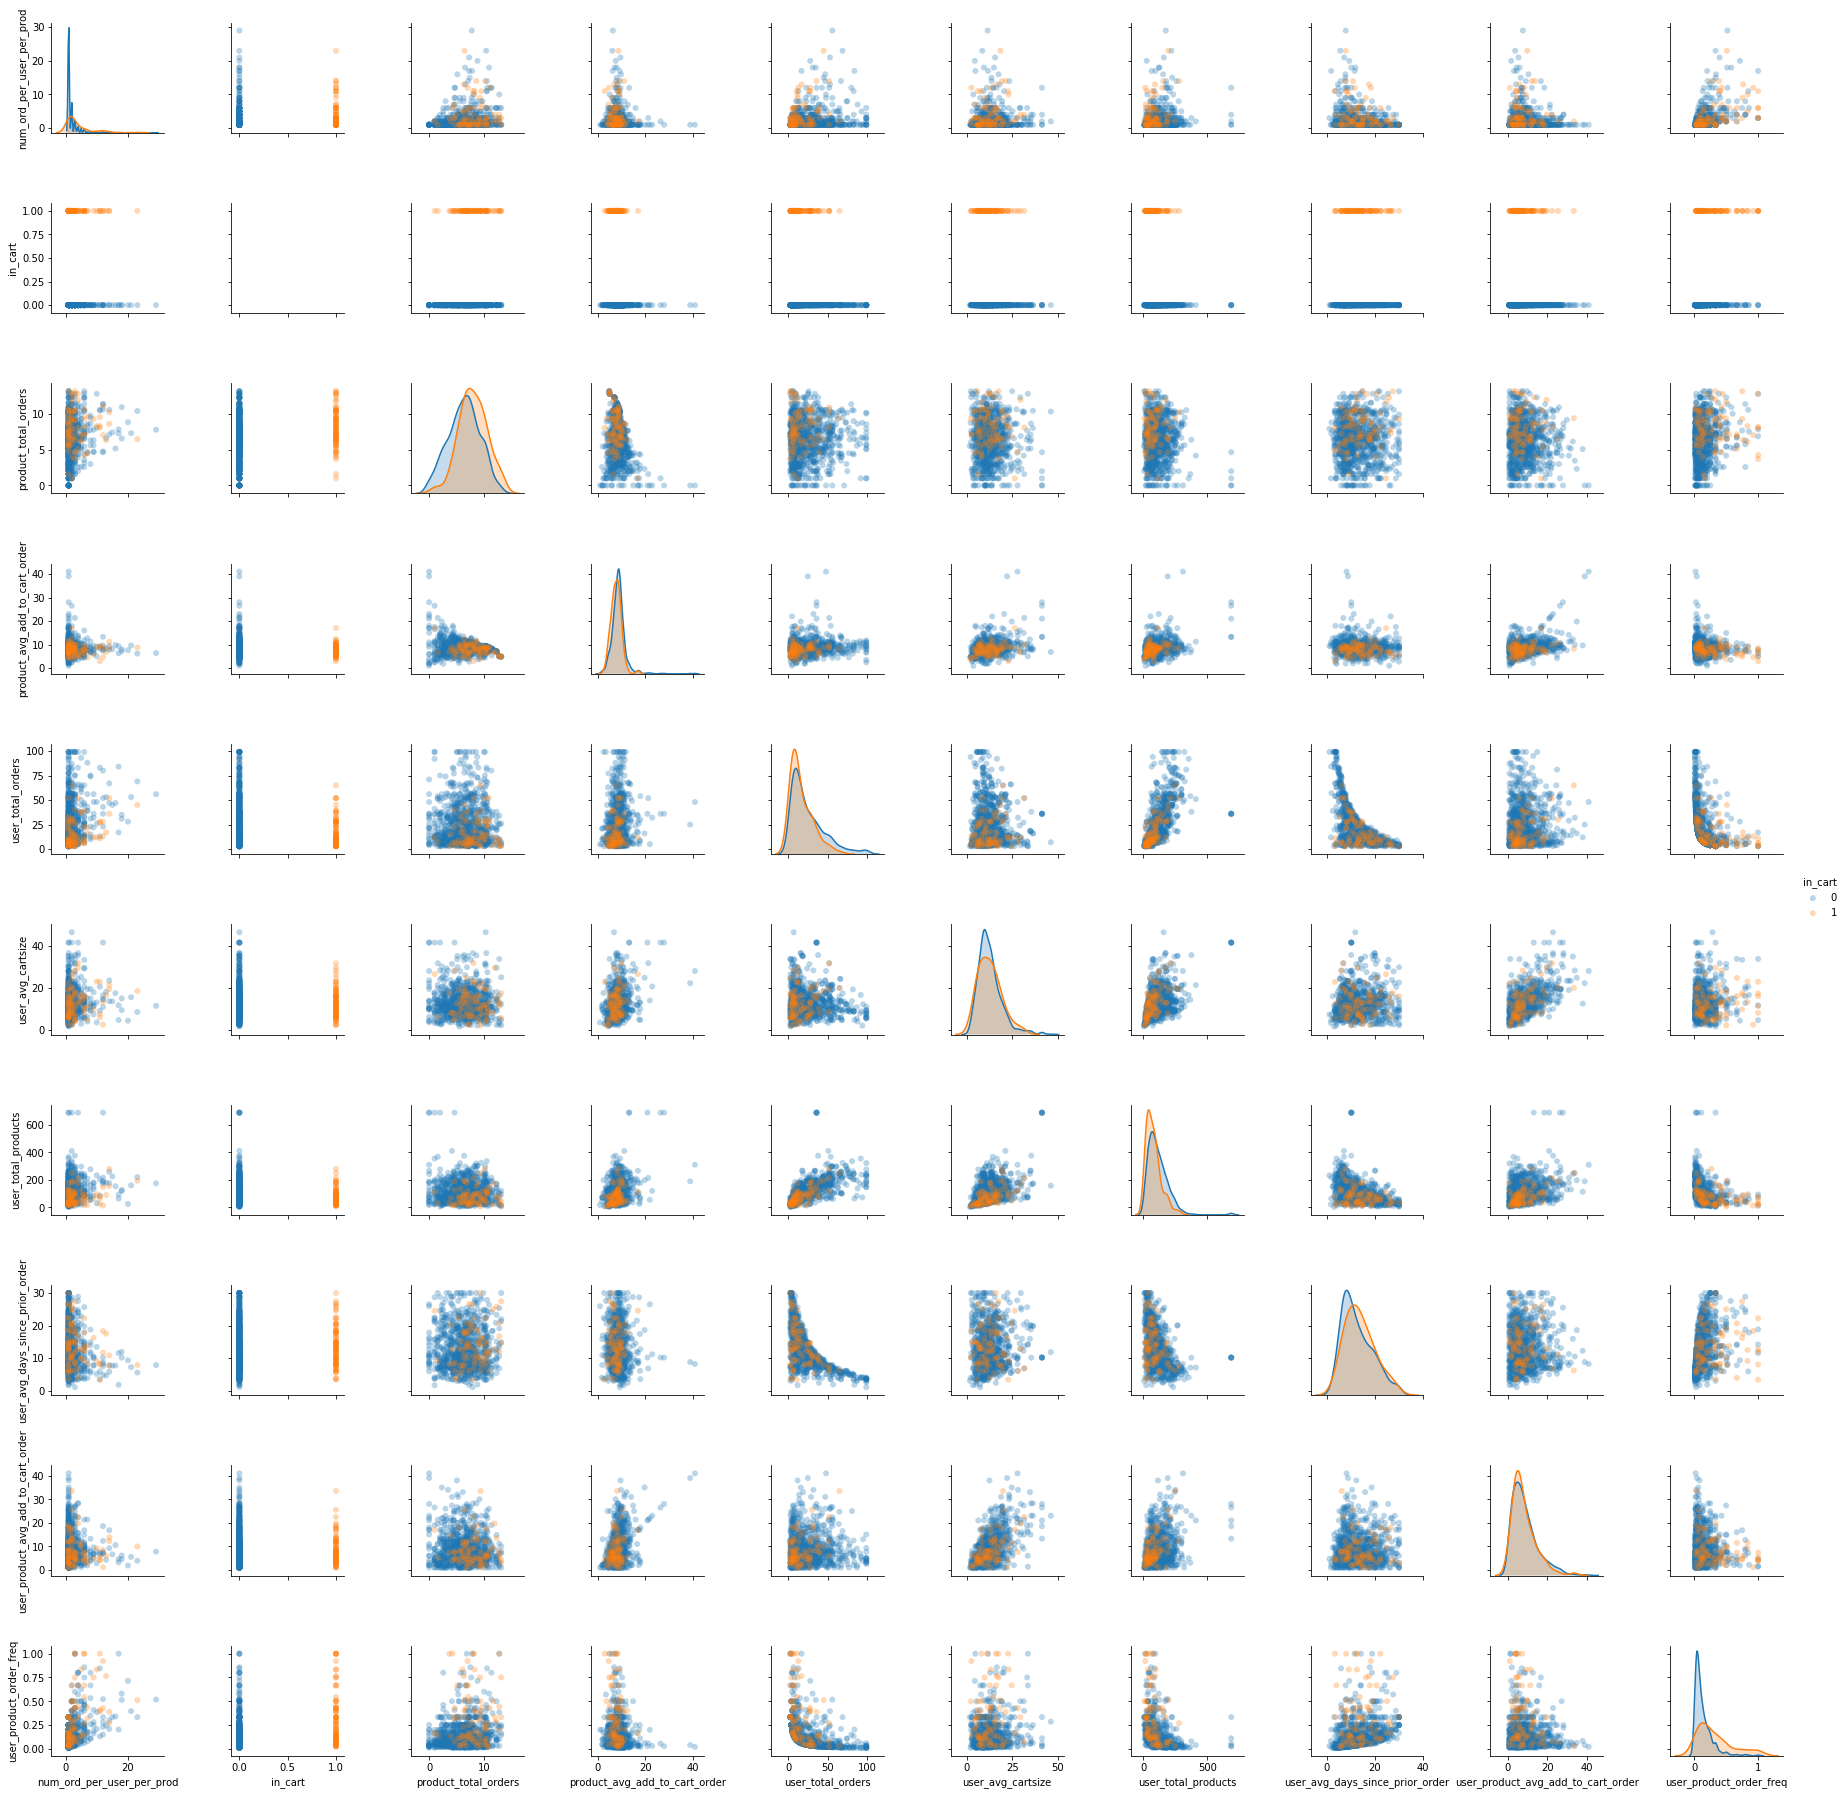

Our f1-score is 0.2187605824585168
The coefficients are: 
                              Features  Coefficients
0           num_ord_per_user_per_prod        0.0884
1                product_total_orders        0.0764
2       product_avg_add_to_cart_order       -0.0391
3                   user_total_orders       -0.0119
4                   user_avg_cartsize        0.0178
5                 user_total_products       -0.0019
6     user_avg_days_since_prior_order       -0.0141
7  user_product_avg_add_to_cart_order        0.0023
8             user_product_order_freq        3.1636
And we've predicted 49063 non-re-orders and 1085 re-orders.


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [16]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Number of Orders Placed Since a Product was Last Ordered
## Percentage of Orders Containing a Product

In [17]:
new_feats = ['total_orders_containig_product','most_recent_order_by_user_by_product']

most_recent_order_by_user_by_product = (ord_prod_prior_df.groupby(['user_id','product_id'],
                                                        as_index=False).agg(OrderedDict(
                                                        [('reordered','sum'),
                                                        ('order_number','max')])))
most_recent_order_by_user_by_product.columns = ['user_id','product_id'] + new_feats

max_orders_per_user = ord_prod_prior_df.groupby(['user_id'],as_index=False).order_number.max()
max_orders_per_user.columns = ['user_id'] + ['number_orders_since_product_last_ordered']

number_orders_since_product_last_ordered = pd.merge(most_recent_order_by_user_by_product, 
                                                    max_orders_per_user,on='user_id')

number_orders_since_product_last_ordered['percent_of_time_product_ordered'] =(
    number_orders_since_product_last_ordered['total_orders_containig_product'] / 
    number_orders_since_product_last_ordered['number_orders_since_product_last_ordered'])
    # Note that we use the column name `number_orders_since_product_last_ordered` as that
    # is currently set to the max order and does not yet actually contain the 
    # number of orders since a product was last ordered.

percent_of_time_product_ordered = number_orders_since_product_last_ordered[['percent_of_time_product_ordered',
                                                                      'user_id','product_id']]

number_orders_since_product_last_ordered = (number_orders_since_product_last_ordered[
                    ['most_recent_order_by_user_by_product','number_orders_since_product_last_ordered']]
                    .diff(axis=1).drop('most_recent_order_by_user_by_product',axis=1))

most_recent_order_by_user_by_product.drop('most_recent_order_by_user_by_product',
                                          axis=1,inplace=True) # we're just using this to get back our product_id and user_id
number_orders_since_product_last_ordered = pd.merge(number_orders_since_product_last_ordered,most_recent_order_by_user_by_product,
                        left_index=True,right_index=True)

combined_feats = pd.merge(number_orders_since_product_last_ordered,percent_of_time_product_ordered,
                        on=['user_id','product_id'])

combined_feats.drop('total_orders_containig_product',axis=1,inplace=True)

df = pd.merge(df, combined_feats,on=['user_id','product_id'])

<Figure size 648x648 with 0 Axes>

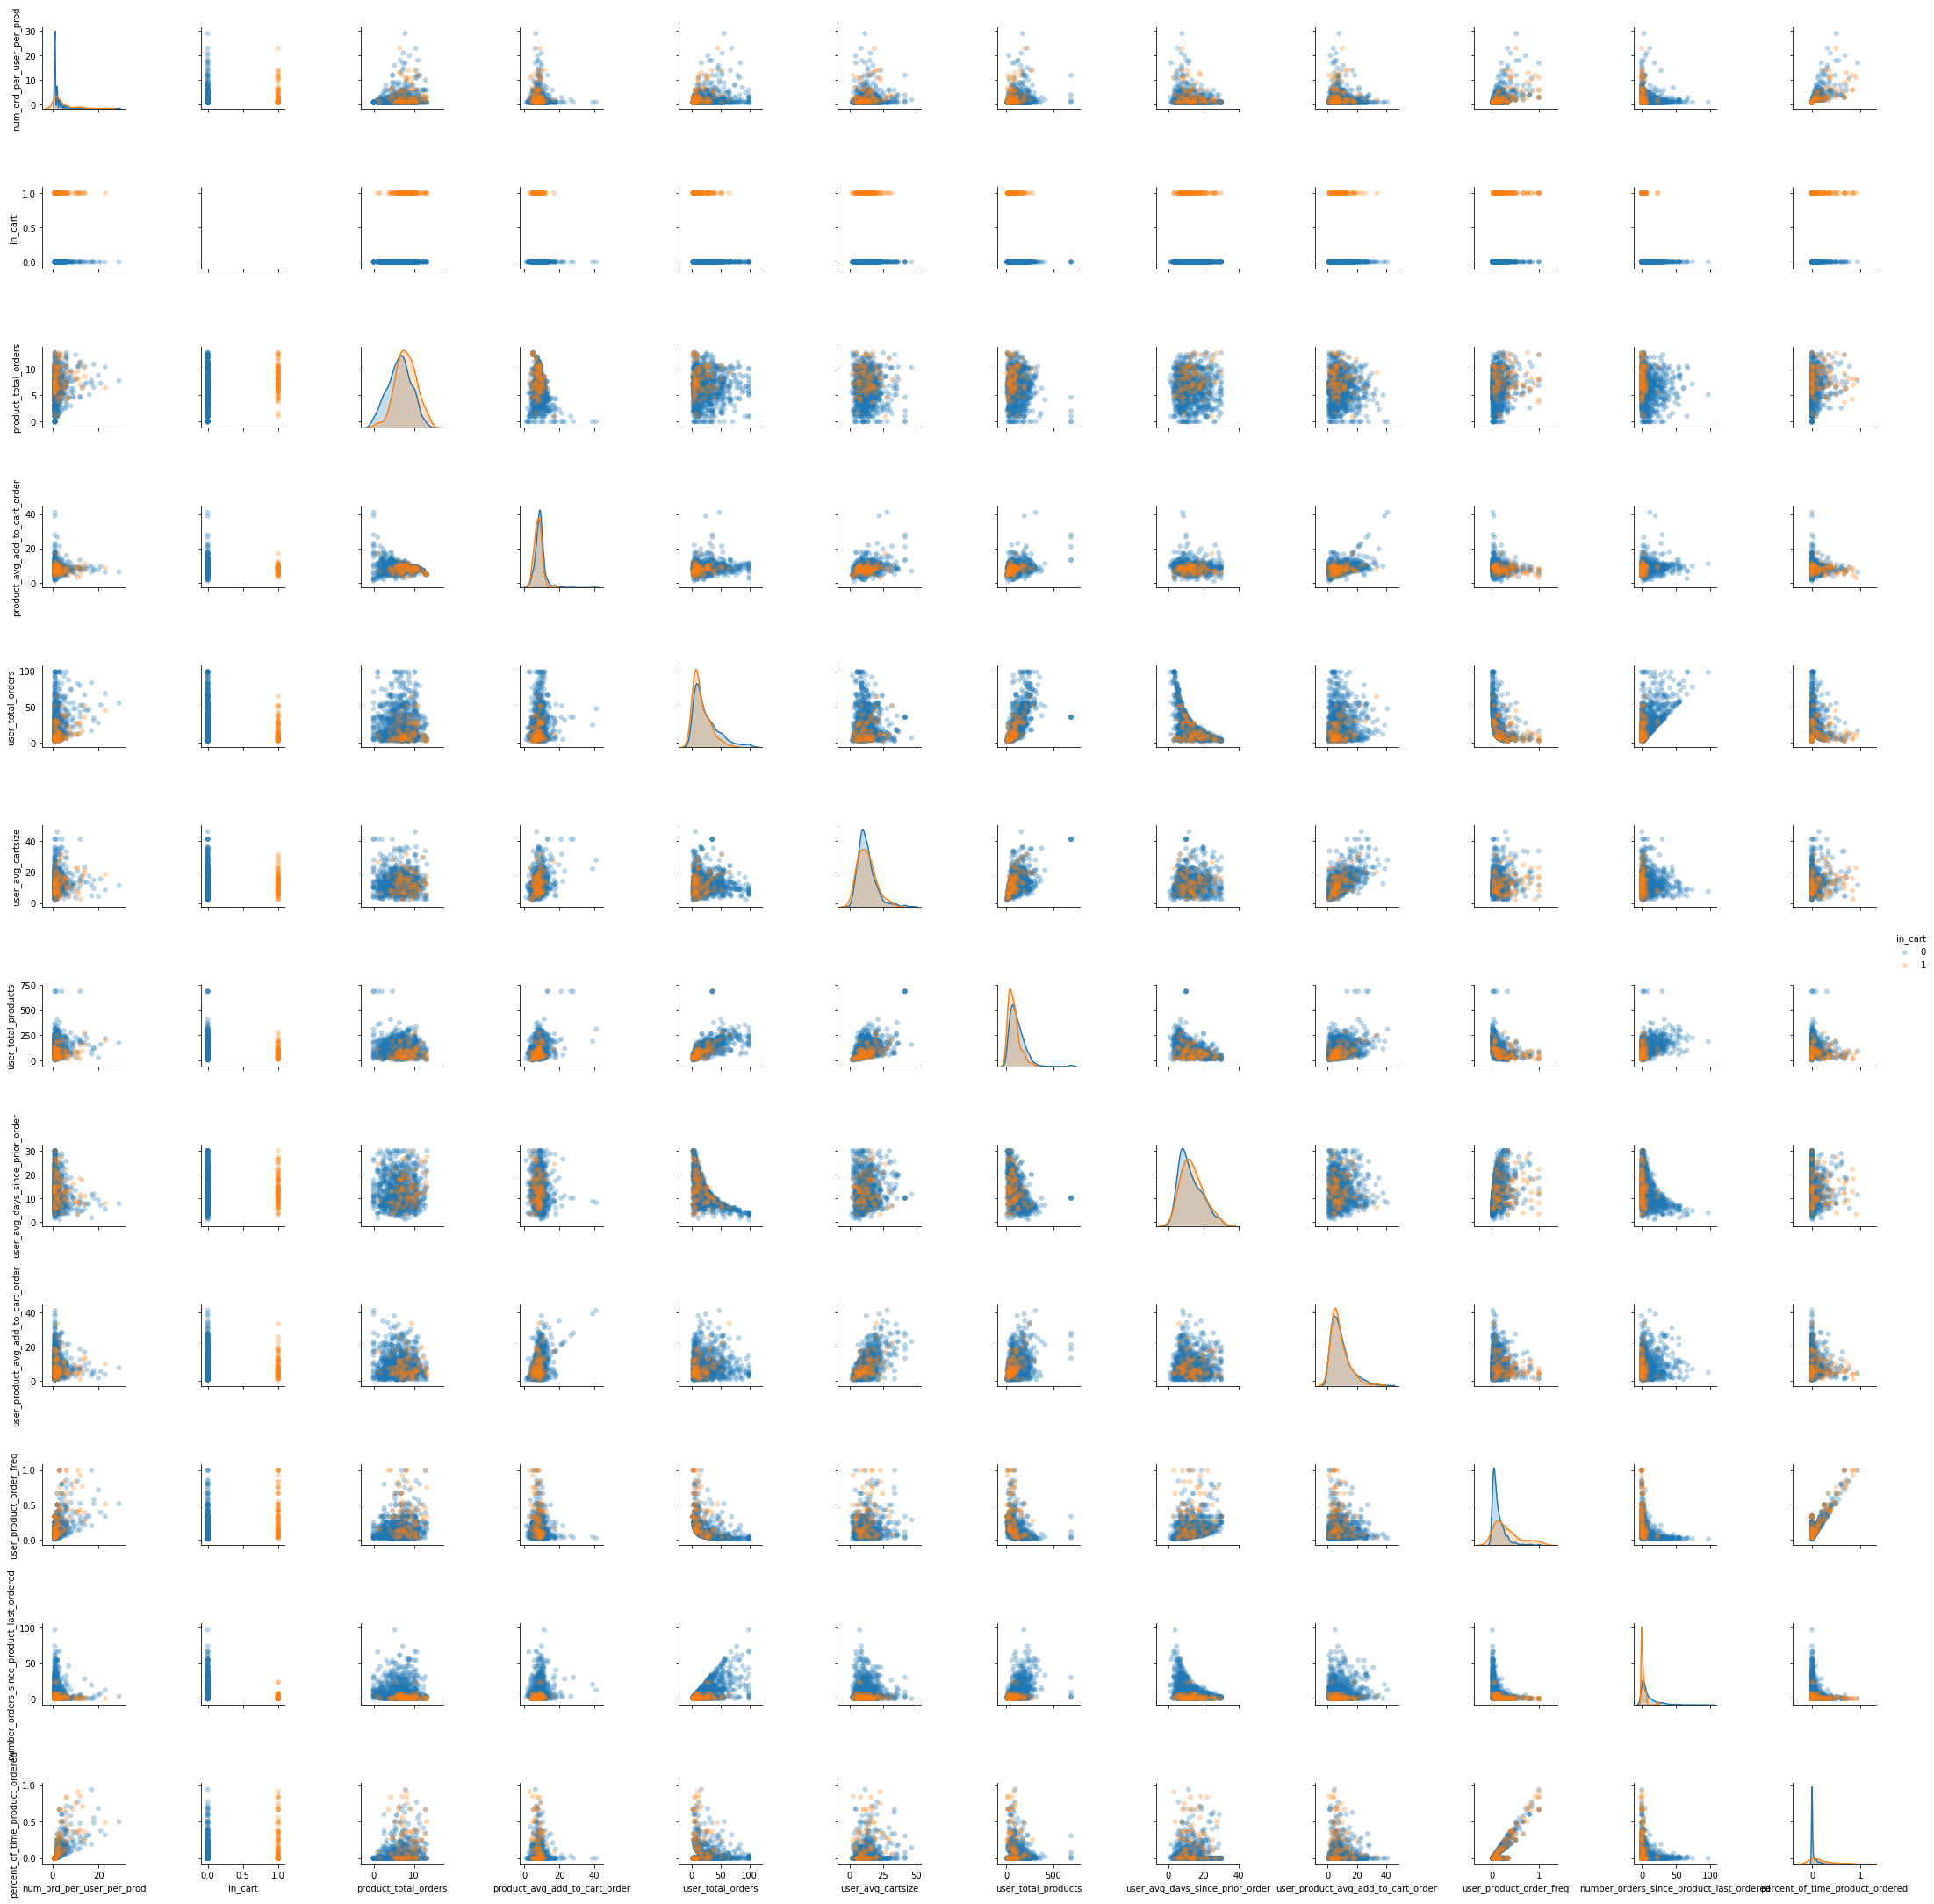

Our f1-score is 0.24568894728198393
The coefficients are: 
                                     Features  Coefficients
0                  num_ord_per_user_per_prod        0.0089
1                       product_total_orders        0.0522
2              product_avg_add_to_cart_order       -0.0608
3                          user_total_orders        0.0084
4                          user_avg_cartsize        0.0210
5                        user_total_products       -0.0020
6            user_avg_days_since_prior_order       -0.0190
7         user_product_avg_add_to_cart_order        0.0008
8                    user_product_order_freq        1.7450
9   number_orders_since_product_last_ordered       -0.1163
10           percent_of_time_product_ordered        2.1059
And we've predicted 48880 non-re-orders and 1268 re-orders.


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [18]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Time since most recent order by user

In [21]:
mean_hod = (ord_df.groupby(['user_id'],as_index=False)
                    .agg({'order_hour_of_day':'mean'}))
mean_hod.columns = ['user_id','mean_order_hour_of_day_by_user']

most_recent_order_time = (ord_df.groupby(['user_id'],as_index=False)
                    .agg({'order_number':'max'}))
temp = pd.merge(most_recent_order_time,ord_df, on=['user_id','order_number'],how='left')
temp = pd.merge(temp[['user_id','order_hour_of_day']], mean_hod, on=['user_id'])
temp['diff_between_average_and_current_order_time'] = (temp['order_hour_of_day'] - 
                                        temp['mean_order_hour_of_day_by_user'])
df = pd.merge(df, temp.drop('order_hour_of_day',axis=1)
              ,on=['user_id'])

<Figure size 648x648 with 0 Axes>

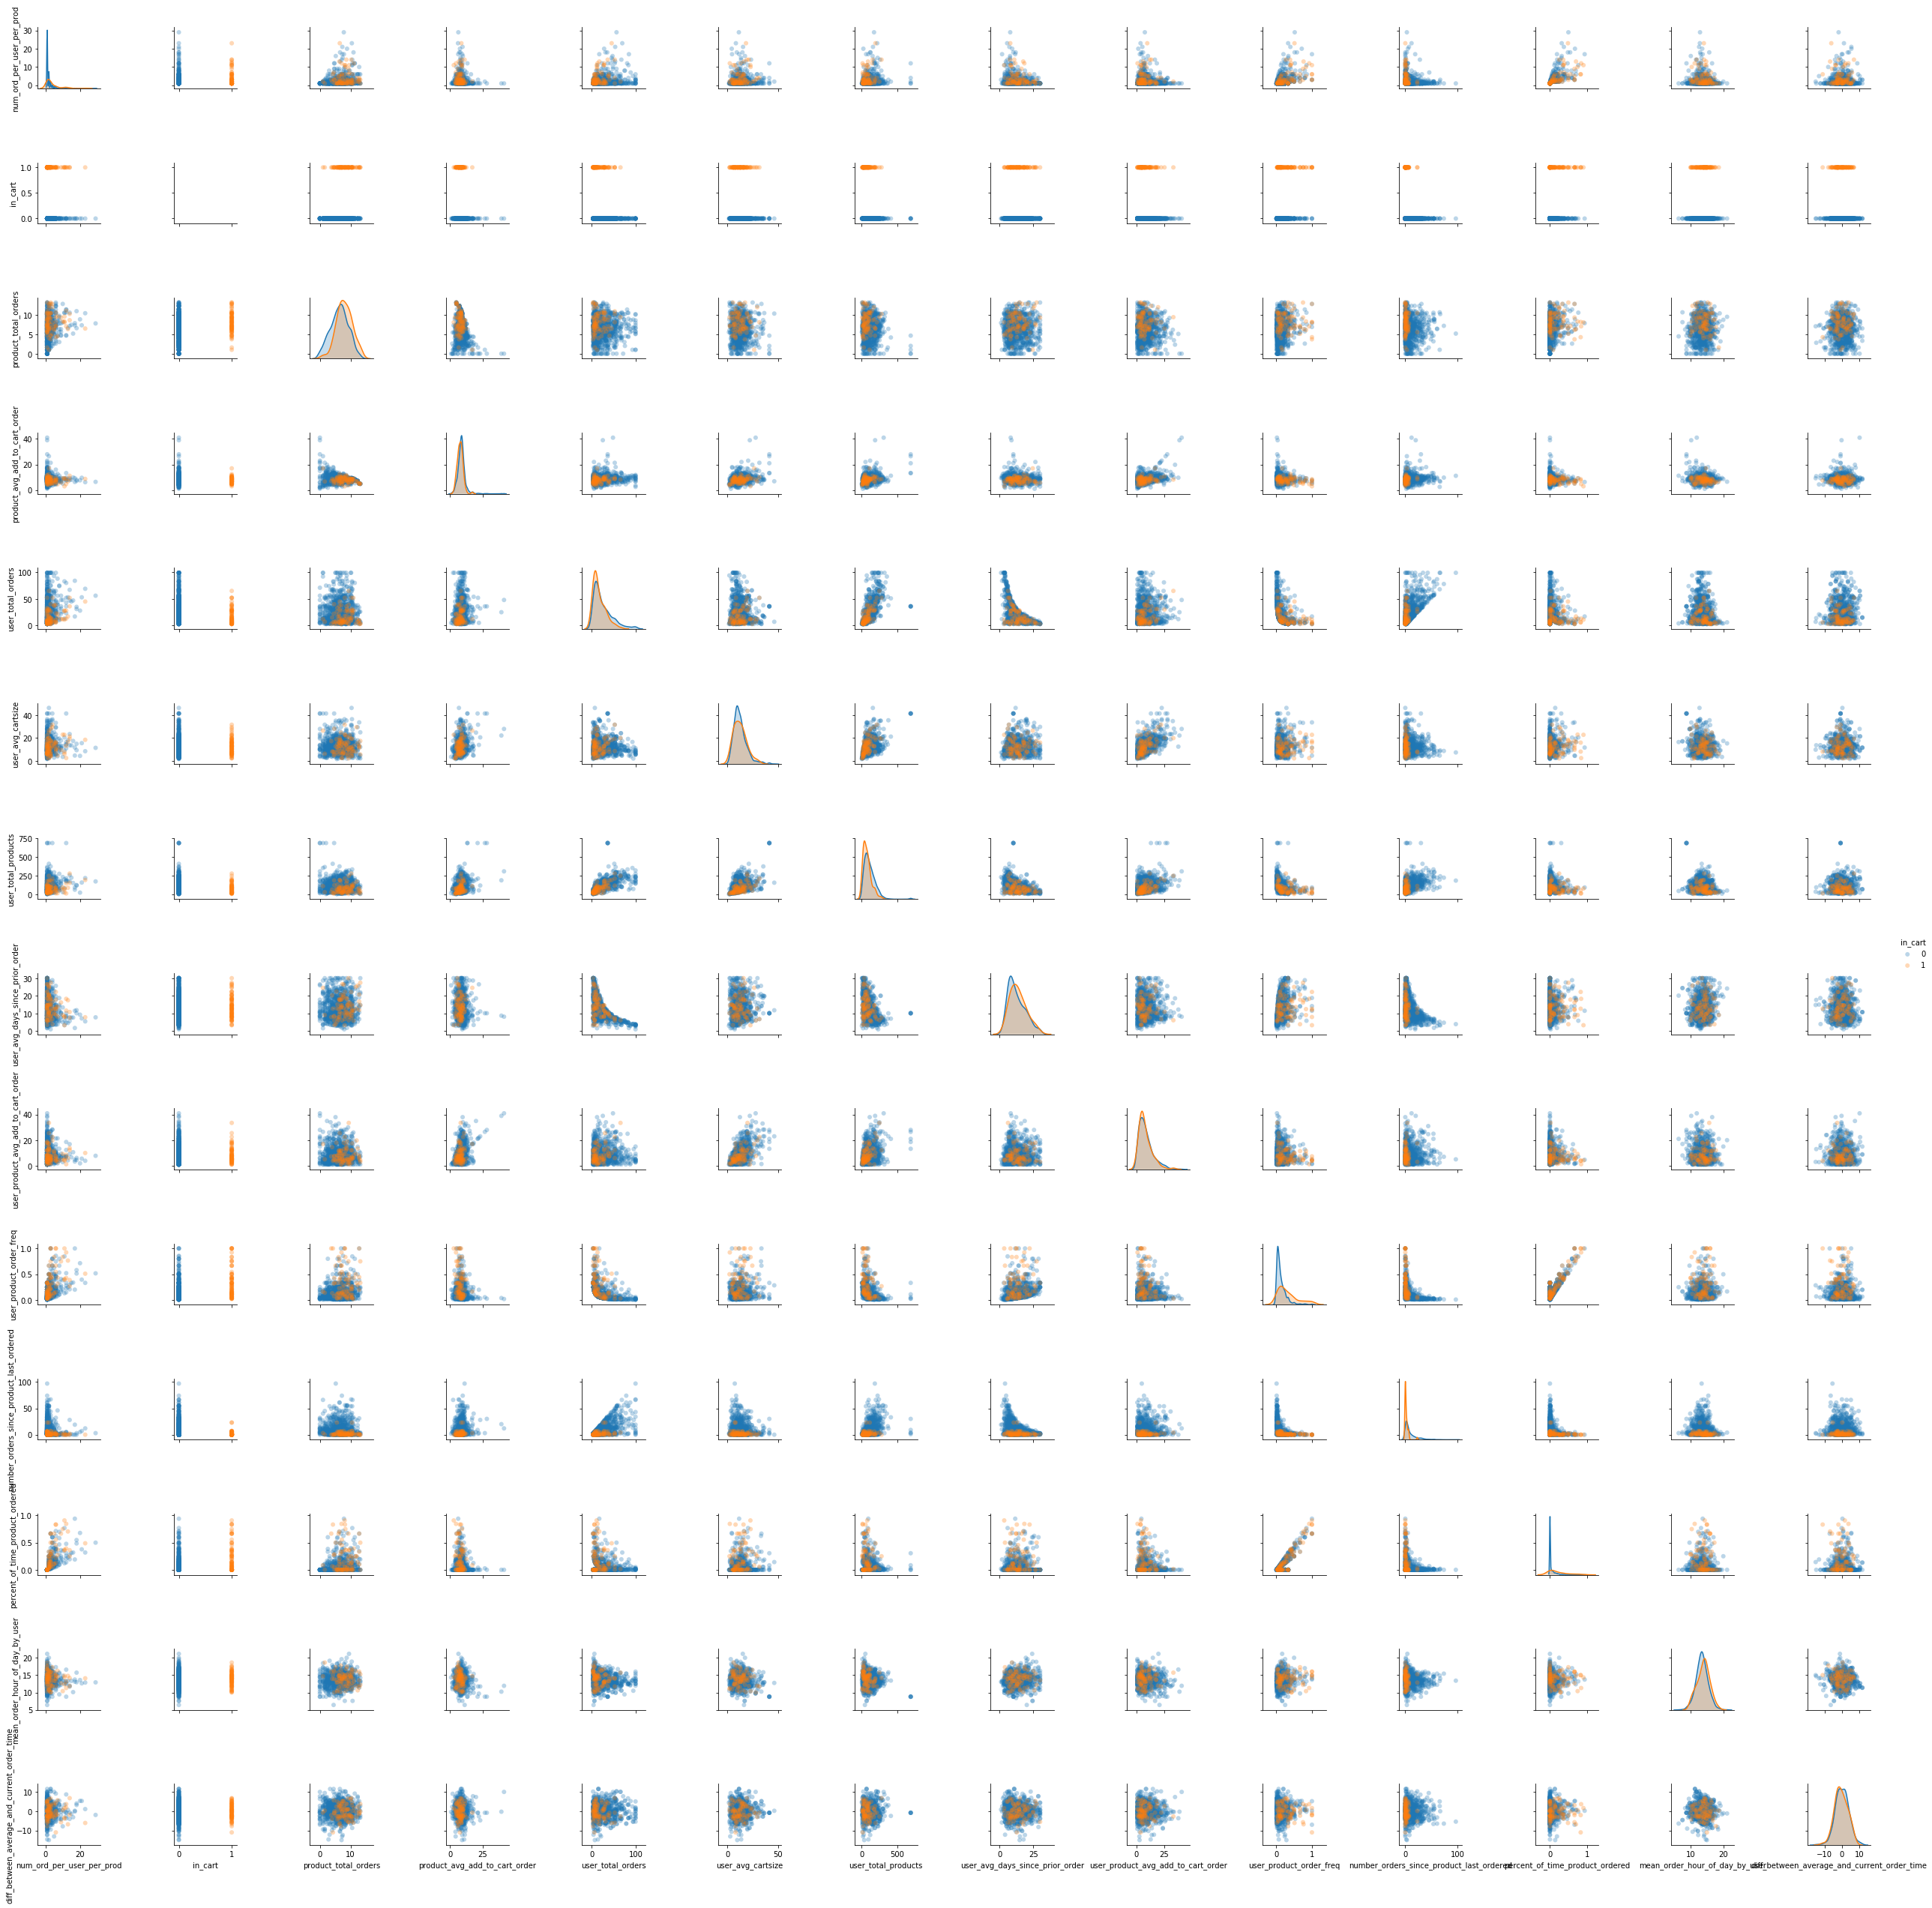

Our f1-score is 0.24002648568117865
The coefficients are: 
                                        Features  Coefficients
0                     num_ord_per_user_per_prod        0.0247
1                          product_total_orders        0.0479
2                 product_avg_add_to_cart_order       -0.0801
3                             user_total_orders        0.0042
4                             user_avg_cartsize        0.0168
5                           user_total_products       -0.0019
6               user_avg_days_since_prior_order       -0.0218
7            user_product_avg_add_to_cart_order        0.0008
8                       user_product_order_freq        1.6286
9      number_orders_since_product_last_ordered       -0.1158
10              percent_of_time_product_ordered        1.7437
11               mean_order_hour_of_day_by_user       -0.0830
12  diff_between_average_and_current_order_time       -0.0095
And we've predicted 48928 non-re-orders and 1220 re-orders.


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [22]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

## Weighting products for more of more recent orders

In [23]:
recent_order_weight = ord_prod_prior_df.loc[:,['product_id', 'reordered', 'user_id', 'order_number']]
max_order_number = ord_df.groupby(['user_id'],as_index=False).agg({'order_number':'max'})
max_order_number.columns = ['user_id','max_order_number']
recent_order_weight = recent_order_weight.merge(max_order_number,on='user_id')
# Here we set max_order_number to be the nth traingular number of the max order number
recent_order_weight['max_order_number'] = ((recent_order_weight.max_order_number *
                                            (recent_order_weight.max_order_number + 1)) / 2)
recent_order_weight['recent_order_weight'] = ((recent_order_weight.reordered 
                                              * recent_order_weight.order_number)
                                              / recent_order_weight.max_order_number)
recent_order_weight = recent_order_weight.groupby(['product_id','user_id'],as_index=False).sum()
recent_order_weight.drop(['reordered','order_number'],axis=1,inplace=True)
df = pd.merge(df, recent_order_weight,on=['user_id','product_id'])

<Figure size 648x648 with 0 Axes>

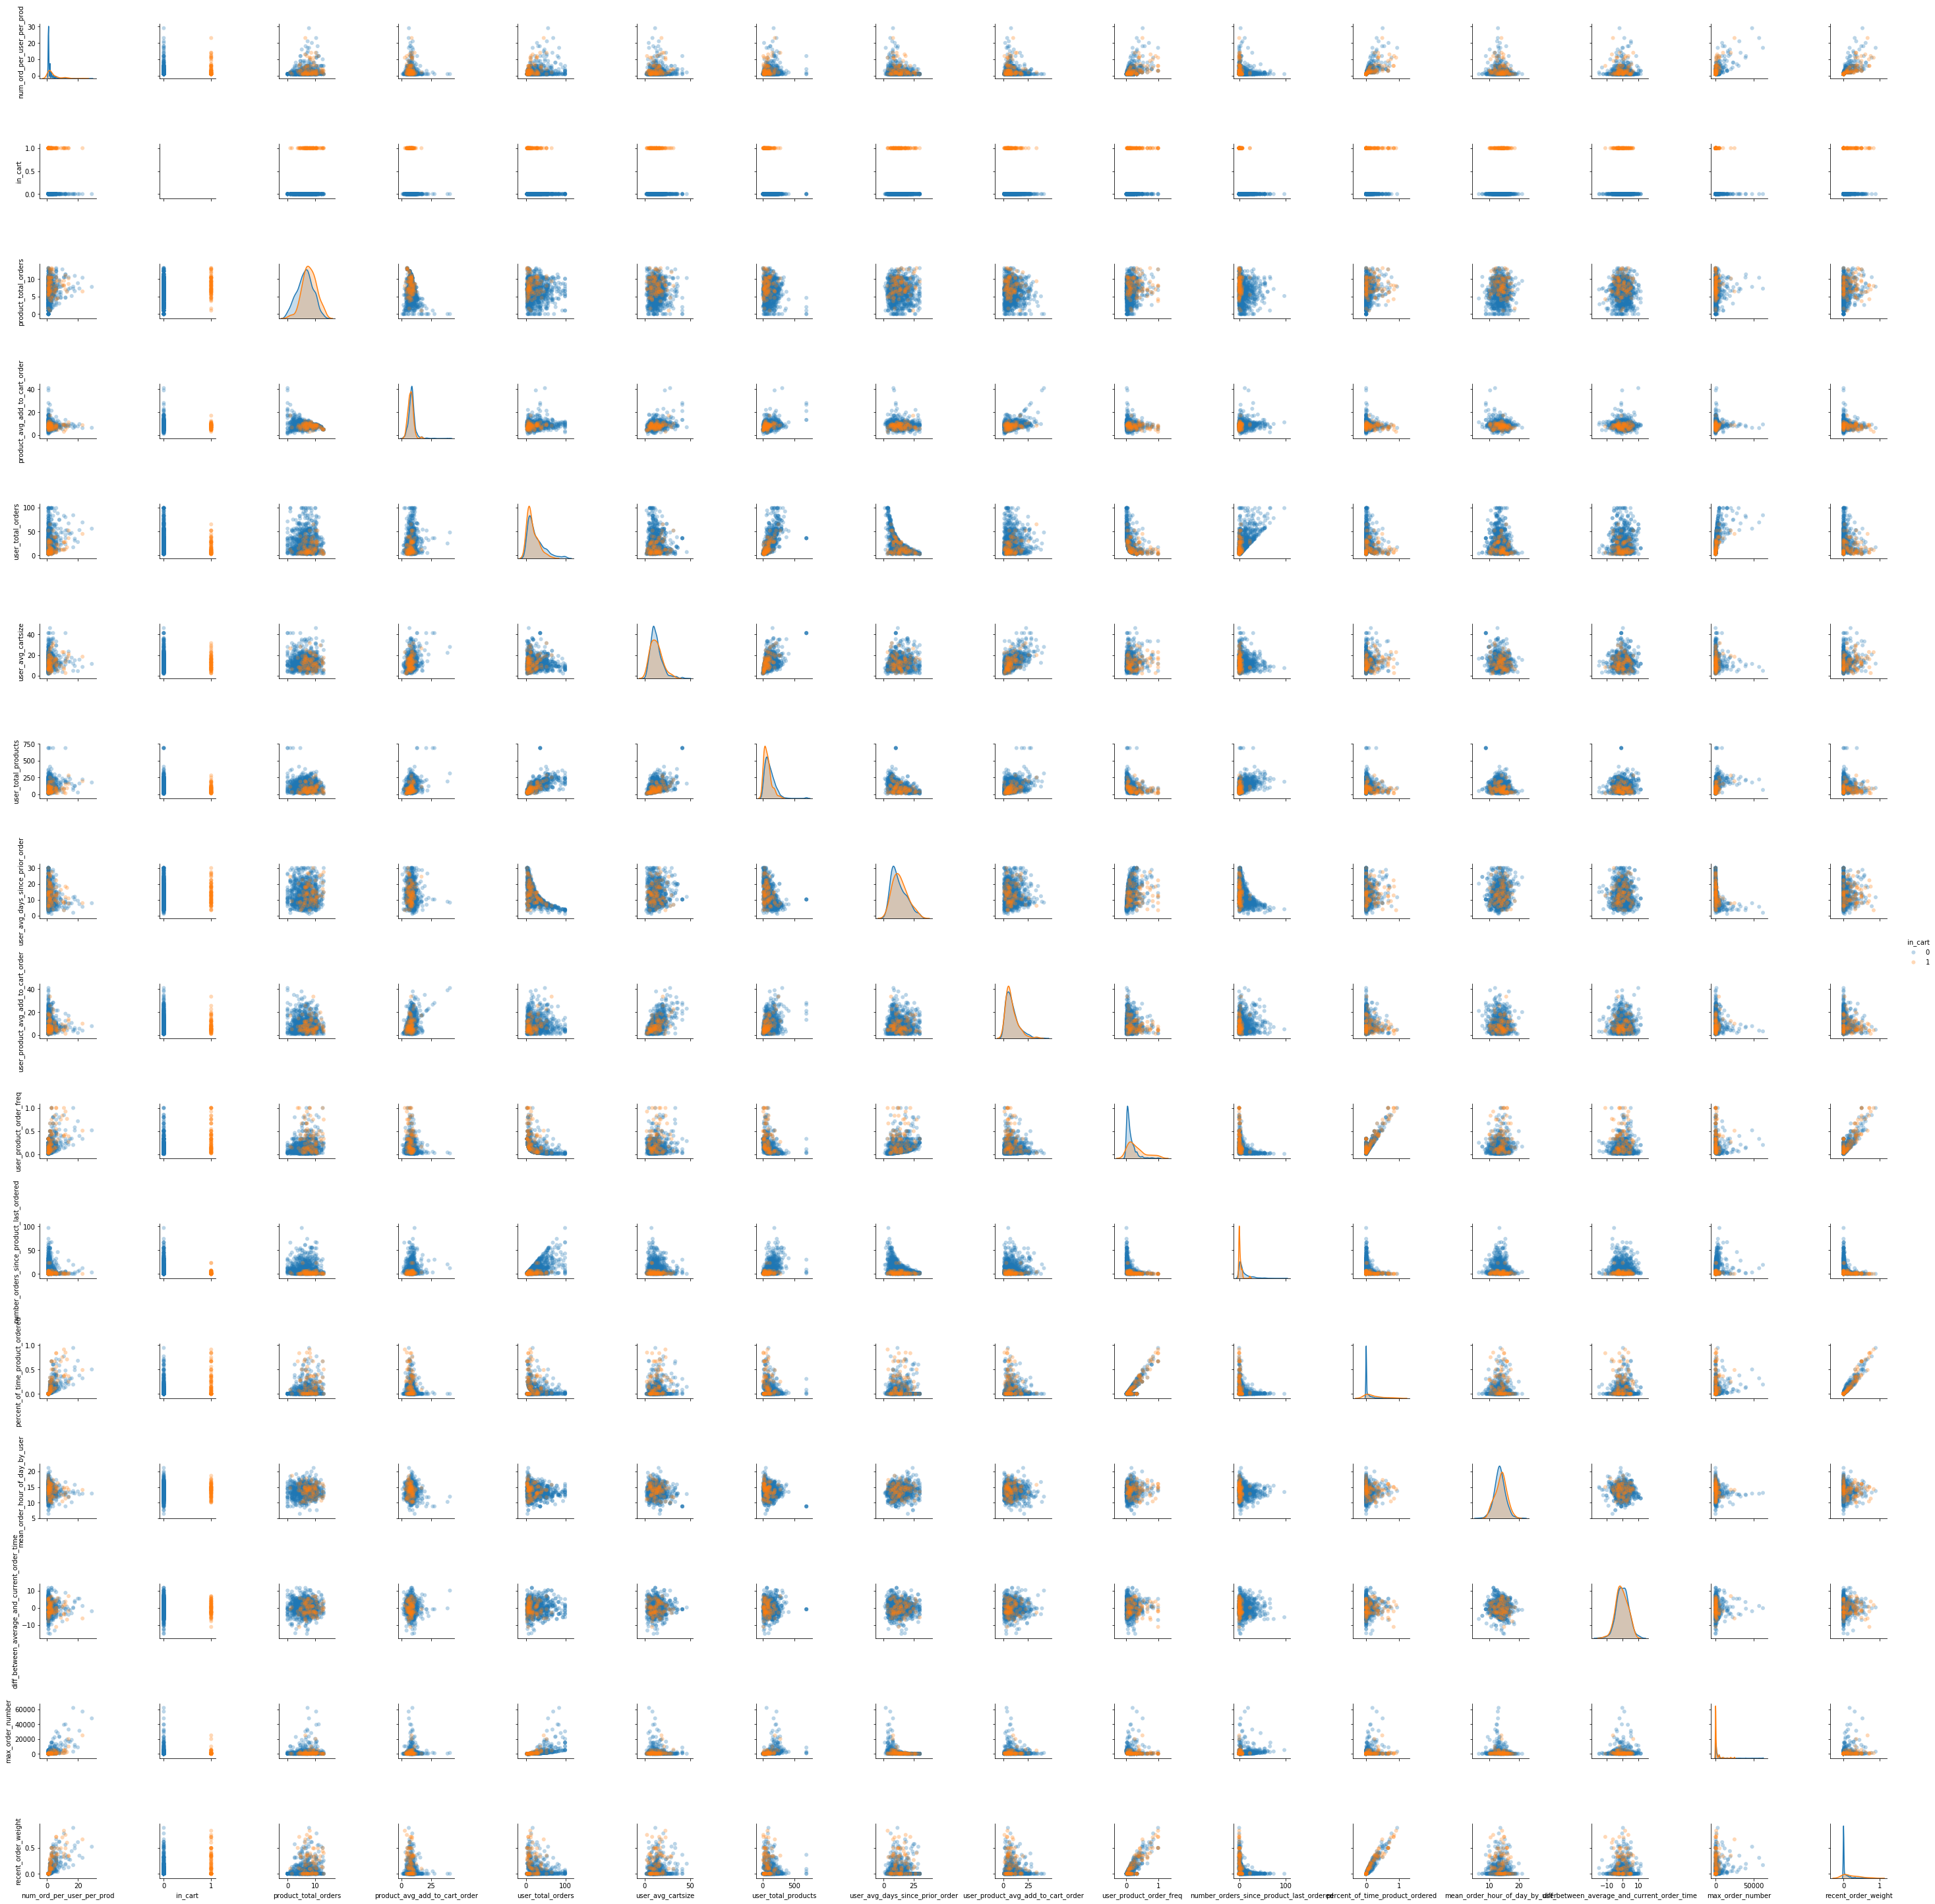

Our f1-score is 0.15171911951973804
The coefficients are: 
                                        Features  Coefficients
0                     num_ord_per_user_per_prod        0.1525
1                          product_total_orders        0.0431
2                 product_avg_add_to_cart_order       -0.0894
3                             user_total_orders        0.0022
4                             user_avg_cartsize        0.0442
5                           user_total_products       -0.0046
6               user_avg_days_since_prior_order       -0.0111
7            user_product_avg_add_to_cart_order       -0.0203
8                       user_product_order_freq        0.0133
9      number_orders_since_product_last_ordered       -0.1501
10              percent_of_time_product_ordered        0.0147
11               mean_order_hour_of_day_by_user       -0.0983
12  diff_between_average_and_current_order_time       -0.0149
13                             max_order_number       -0.0000
14        

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [24]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

### Removing Max Order Number
Max order number clearly had a significant negative impact and has been removed.

In [25]:
df.drop(['max_order_number'],axis=1,inplace=True)

<Figure size 648x648 with 0 Axes>

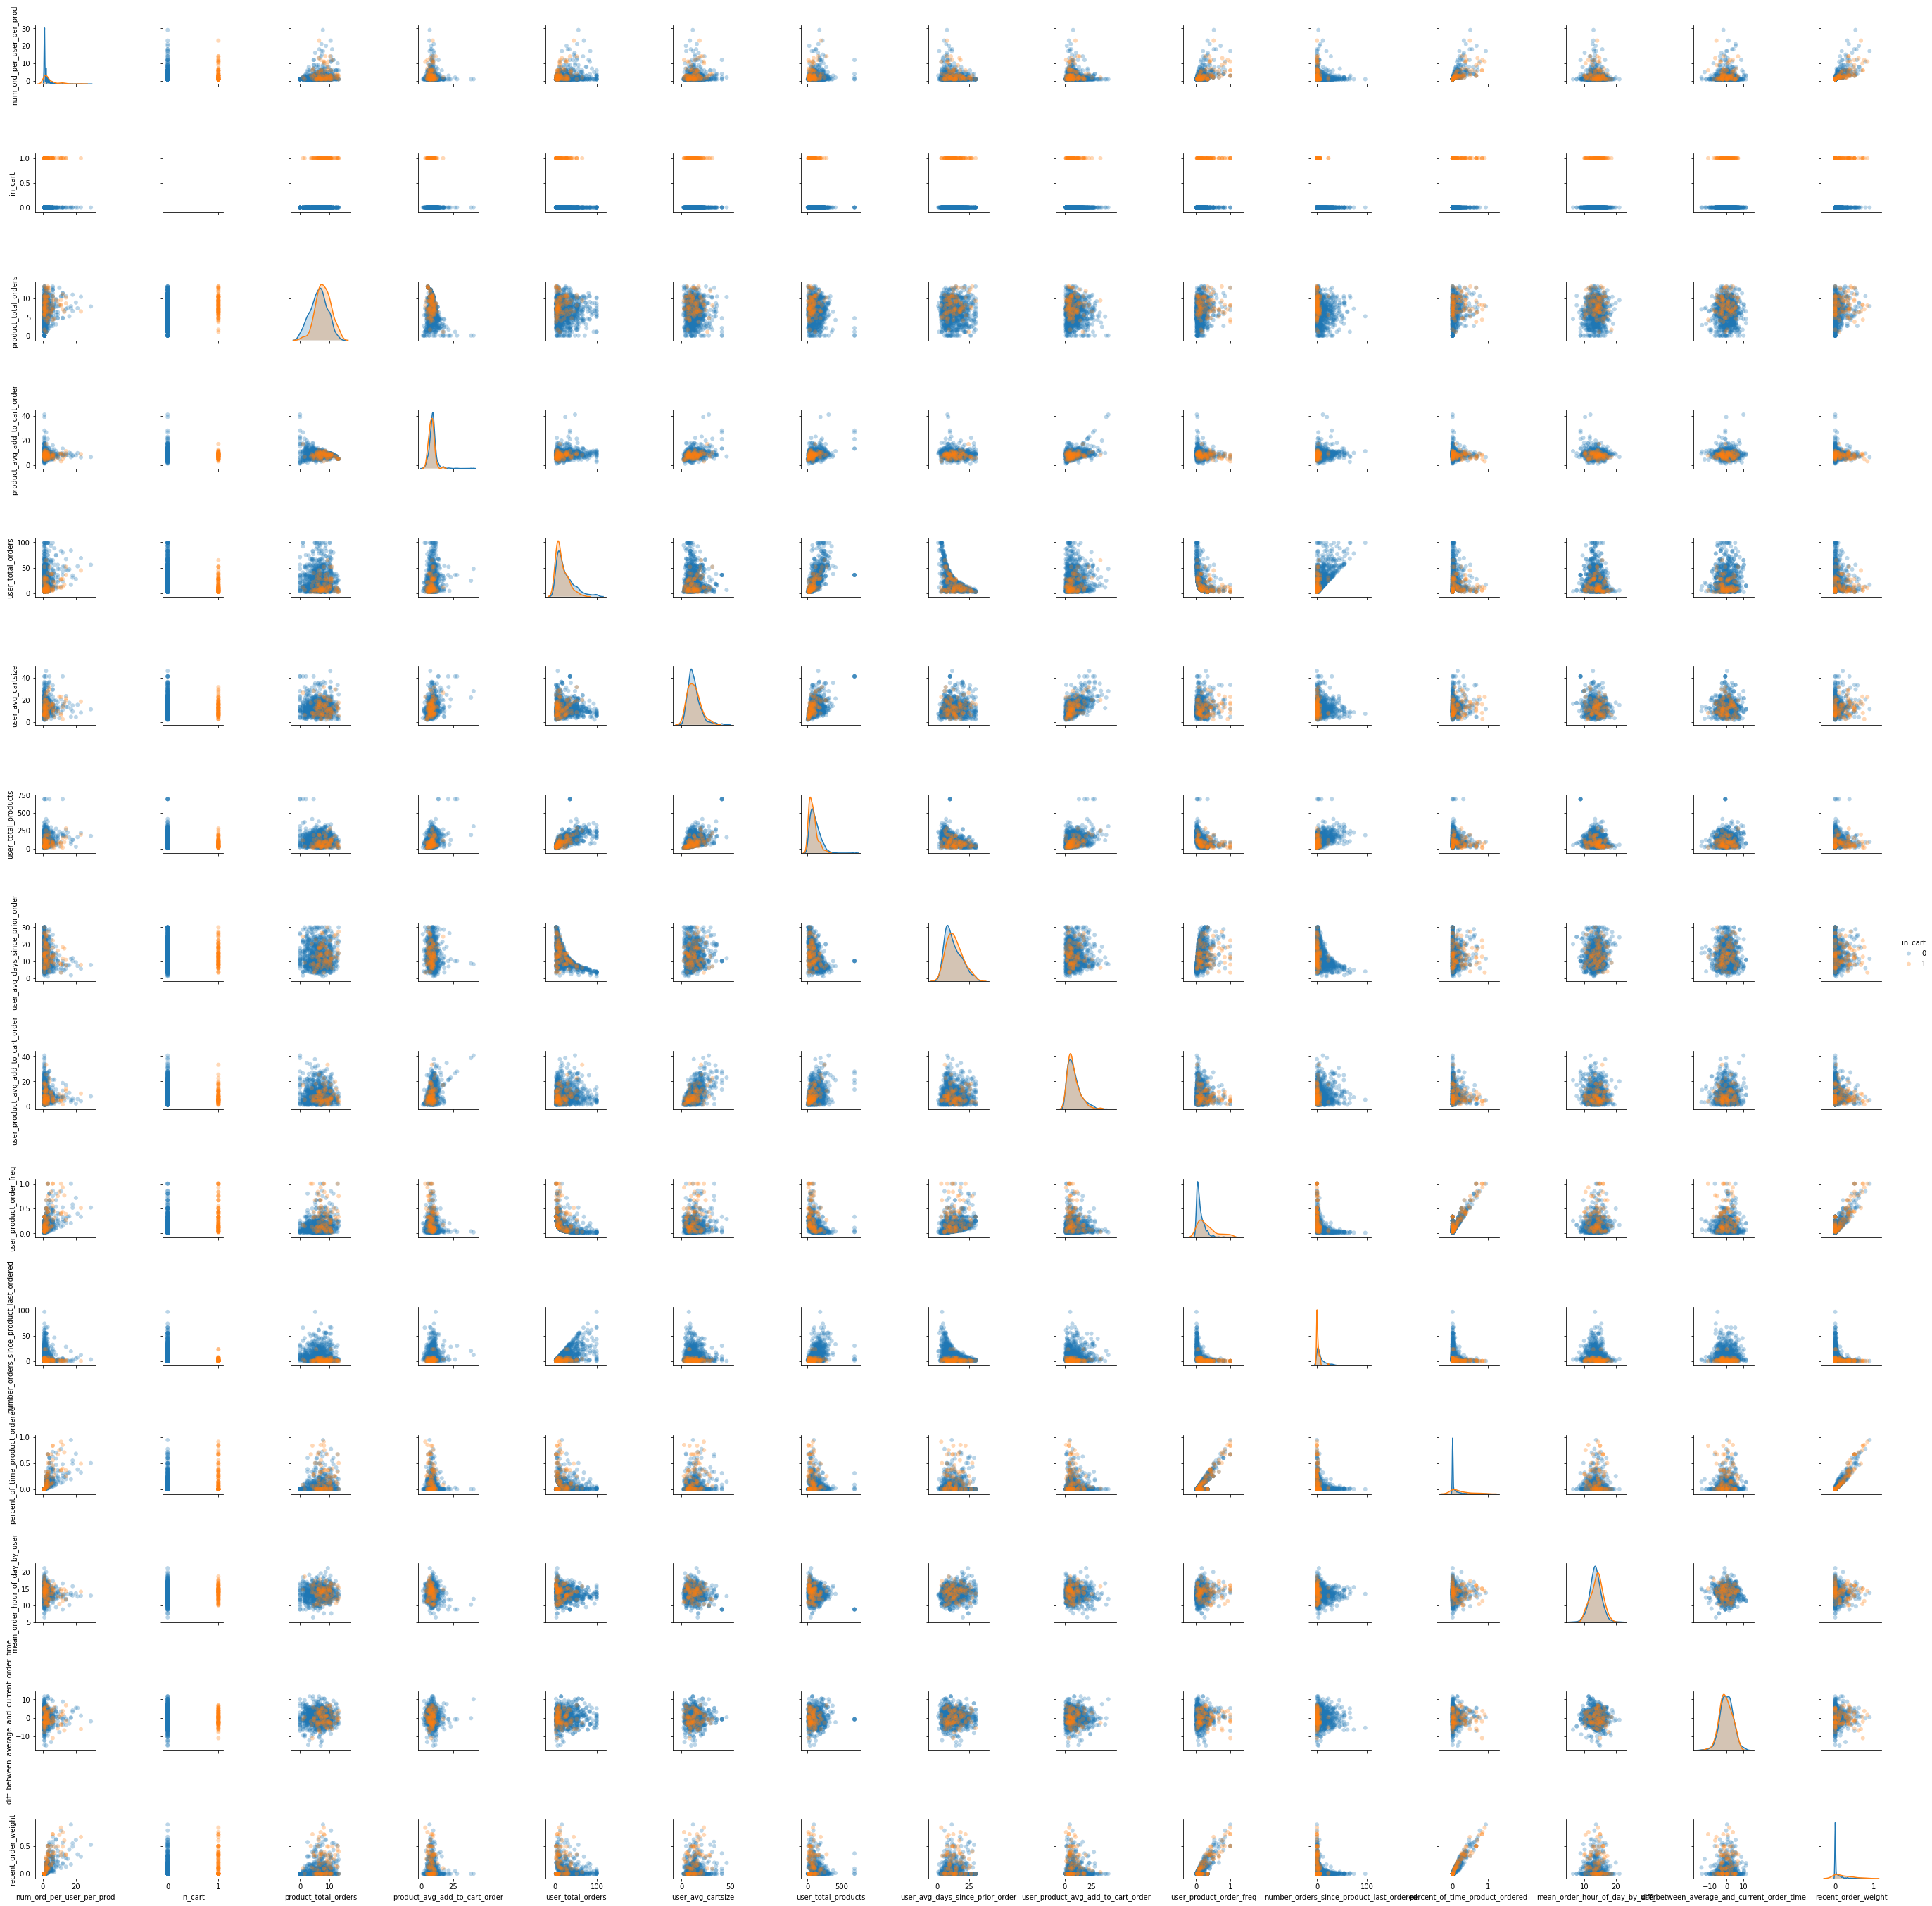

Our f1-score is 0.25419039869812854
The coefficients are: 
                                        Features  Coefficients
0                     num_ord_per_user_per_prod        0.0029
1                          product_total_orders        0.0417
2                 product_avg_add_to_cart_order       -0.0727
3                             user_total_orders        0.0066
4                             user_avg_cartsize        0.0204
5                           user_total_products       -0.0025
6               user_avg_days_since_prior_order       -0.0200
7            user_product_avg_add_to_cart_order       -0.0003
8                       user_product_order_freq        1.2600
9      number_orders_since_product_last_ordered       -0.1155
10              percent_of_time_product_ordered        1.3527
11               mean_order_hour_of_day_by_user       -0.0970
12  diff_between_average_and_current_order_time       -0.0118
13                          recent_order_weight        1.4278
And we've 

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [26]:
X_tr, X_val, y_tr, y_val = get_user_split_data(df)
plot_fit_score_pred(df, X_tr, X_val, y_tr, y_val)

In [27]:
pd.to_pickle(df,'investigation_df')